# Kaggle Loan Defaulter Problemset

#### Here we will use Nvidia rapids libraries cuml, cudf to use graphics card instead CPU
#### Let's import all the libraries required

In [1]:
import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Reading csv file to dataframe using cudf

In [2]:
dataset = cudf.read_csv('../input/loan-default-dataset/Loan_Default.csv')
dataset.head(5)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.72881356,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,<NA>,North,direct,1,<NA>
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.01968504,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.3768997,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.88654354,North,direct,0,39.0


### There are 34 feature vectors in this dataset and DataFrame is not displaying all of them. To solve this we can set number of columns we want to display with pandas settings as shown in the cell below:


In [3]:
pd.set_option("display.max_columns", dataset.shape[-1]) 
dataset.head(5)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,<NA>,<NA>,<NA>,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.72881356,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,<NA>,<NA>,<NA>,360.0,not_neg,not_int,lpsm,<NA>,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,<NA>,North,direct,1,<NA>
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.01968504,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.681,<NA>,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.3768997,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.0,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.88654354,North,direct,0,39.0


### Feature vector ID is not useful, we can just drop it and if we have data of only year then it's not a timeseries problem, we can drop that as well. Let's check how many unique values we have in the year feature vector

In [4]:
dataset['year'].unique()

0    2019
Name: year, dtype: int64

### This data is only for the year 2019, it's same for all the vector this we can drop this as well.
### In the cell below we will drop ID, and year feature vector

In [5]:
# axis=1 = columns and 0 = rows
dataset.drop(['ID', 'year'], axis=1, inplace=True)
dataset.head(5)

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,<NA>,<NA>,<NA>,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.72881356,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,<NA>,<NA>,<NA>,360.0,not_neg,not_int,lpsm,<NA>,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,<NA>,North,direct,1,<NA>
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.01968504,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.681,<NA>,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.3768997,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.0,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.88654354,North,direct,0,39.0


### We want to be sure that our dataset is not biased and we have enough number of records for all categories in our dataset.

### In the cell below we'll plot the barplot to check the same.

This dataset has features: 32
Total number of samples in the dataset rows: 148670


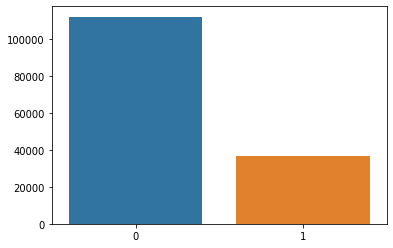

In [6]:
n_rows, n_features = dataset.shape
print (f"This dataset has features: {n_features}")
print (f"Total number of samples in the dataset rows: {n_rows}")

# We also need to make sure that we have enough data to test all the categories
# Status is our dependent feature
dist = dataset.groupby(by="Status").size()

_ = sns.barplot(x=dist.index.values_host, y=dist.values.get())

### Observations:
1. The dataset has lot of values for class 0 and compared to that very few values for the class 1. But this should be enough for training the model. But,
2. While splitting the dataset to train and test, we need to make sure that we have enough number of class 1 samples in the test array.

## Checking the null values in the dataset

In [7]:
null_cols_status_0 = dataset[dataset["Status"] == 0].isnull().sum() # we can also use isnull method both are same
null_cols_status_1 = dataset[dataset["Status"] == 1].isnull().sum() # we can also use isnull method both are same

print (f"Maximum number of null values in the class 0: {np.max(null_cols_status_0)}")
print (f"Maximum number of null values in the class 1: {np.max(null_cols_status_1)}")

Maximum number of null values in the class 0: 7911
Maximum number of null values in the class 1: 36639


## Observations:
1. For the class 0 we have 7,911 null values, if we dropped all of these it would be fine because we still will have enough number of samples to train the model. But,
2. For the class 1 we maybe have just enough data to train our model and we can't just drop all the 36,639 rows.
3. We need to replace the null values with some statistically appropriate data for all the feture vector with null values in them.

### In the following cell we will get the all the feature names which has null values.

In [8]:
temp0 = set(null_cols_status_0.index[null_cols_status_0 > 0].values_host)
temp1 = set(null_cols_status_0.index[null_cols_status_1 > 0].values_host)

cols_with_na_values = list(temp0.union(temp1))
del temp0, temp1

cols_with_na_values

['loan_limit',
 'approv_in_adv',
 'Neg_ammortization',
 'age',
 'income',
 'term',
 'dtir1',
 'loan_purpose',
 'LTV',
 'property_value',
 'submission_of_application',
 'rate_of_interest',
 'Upfront_charges',
 'Interest_rate_spread']

## Before performing any statistical operatings we need to see that all the features are stored in the DataFrame with appropriate datatypes

In [9]:
dataset.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   loan_limit                 145326 non-null  object
 1   Gender                     148670 non-null  object
 2   approv_in_adv              147762 non-null  object
 3   loan_type                  148670 non-null  object
 4   loan_purpose               148536 non-null  object
 5   Credit_Worthiness          148670 non-null  object
 6   open_credit                148670 non-null  object
 7   business_or_commercial     148670 non-null  object
 8   loan_amount                148670 non-null  int64
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          148549 non-nul

### Obervations:
1. As you can see lots of features are stored with obeject datatype, in this case it is not necessary that all of them are having string values but some integer or float values may be are stored as string in the dataframe.

## Let's check what kind of values all the feature vectors have.

In [10]:
for column in dataset.columns:
    print (dataset.loc[:, column].unique())

0    <NA>
1      cf
2     ncf
Name: loan_limit, dtype: object
0               Female
1                Joint
2                 Male
3    Sex Not Available
Name: Gender, dtype: object
0     <NA>
1    nopre
2      pre
Name: approv_in_adv, dtype: object
0    type1
1    type2
2    type3
Name: loan_type, dtype: object
0    <NA>
1      p1
2      p2
3      p3
4      p4
Name: loan_purpose, dtype: object
0    l1
1    l2
Name: Credit_Worthiness, dtype: object
0    nopc
1     opc
Name: open_credit, dtype: object
0      b/c
1    nob/c
Name: business_or_commercial, dtype: object
0        16500
1        26500
2        36500
3        46500
4        56500
        ...   
206    2926500
207    2986500
208    3006500
209    3346500
210    3576500
Name: loan_amount, Length: 211, dtype: int64
0       <NA>
1        0.0
2      2.125
3       2.25
4      2.375
       ...  
127    7.125
128    7.375
129      7.5
130     7.75
131      8.0
Name: rate_of_interest, Length: 132, dtype: float64
0           <NA>
1     

## Observations:
1. There are lot of feature vectors with string categorical data, we need to convert those to integer data i.e. assigning a number to each category.
2. Once categorical features are encoded then we can change datatype of that feature to integer.

### We have lots of 34 features in this dataset checking for categorical feature vectors can take time.
### We will automate this in the following manner:
1. We can try to find columns which has categorical values with based on how many number of unique values that feature has. <br/>
For Ex: ```loan_limit``` feature is a categoriacal vector and has <b>2 unique</b> categories <b>cf</b> and <b>ncf</b>.
2. Like the example above we can for all the categorical feature vectors, if a vector has < x number of unique values then we can categorize it as categorical feature.
3. Here in the following cell we have ```n_unique_values``` variable which we will set to <b>10</b>. Which means if any vector has < 10 unique values then it's categorical variable.

In [11]:
n_unique_values = 10
all_columns = dataset.columns.to_list()
categorical_columns = []

for i, column in enumerate(all_columns):
    temp = dataset.loc[:, column].unique().to_arrow().to_pylist()
    if len(temp) < n_unique_values:
        print (f"{i+1}. {column} has {len(temp)} unique values, which are {temp}") 
        categorical_columns.append(column)
del temp

1. loan_limit has 3 unique values, which are [None, 'cf', 'ncf']
2. Gender has 4 unique values, which are ['Female', 'Joint', 'Male', 'Sex Not Available']
3. approv_in_adv has 3 unique values, which are [None, 'nopre', 'pre']
4. loan_type has 3 unique values, which are ['type1', 'type2', 'type3']
5. loan_purpose has 5 unique values, which are [None, 'p1', 'p2', 'p3', 'p4']
6. Credit_Worthiness has 2 unique values, which are ['l1', 'l2']
7. open_credit has 2 unique values, which are ['nopc', 'opc']
8. business_or_commercial has 2 unique values, which are ['b/c', 'nob/c']
14. Neg_ammortization has 3 unique values, which are [None, 'neg_amm', 'not_neg']
15. interest_only has 2 unique values, which are ['int_only', 'not_int']
16. lump_sum_payment has 2 unique values, which are ['lpsm', 'not_lpsm']
18. construction_type has 2 unique values, which are ['mh', 'sb']
19. occupancy_type has 3 unique values, which are ['ir', 'pr', 'sr']
20. Secured_by has 2 unique values, which are ['home', 'land

## Observations:
1. We will encode these categorical values before we fix the NA values, but encoder may end up assigning a category to NA values. We need to make sure that it does not happen.
2. Feature vector ```Gender``` has a value ```Sex Not Available``` which are essentially NA values.
3. Ignore status while performing encode.

### Replacing ```Sex Not Available``` with ```np.nan``` in feature vector ```Gender```.

In [12]:
dataset["Gender"] = dataset["Gender"].replace("Sex Not Available", np.nan)

### Updating ```cols_with_na_values``` adding ```Gender``` to it

In [13]:
if "Gender" not in cols_with_na_values:
    cols_with_na_values.append("Gender")
    print (cols_with_na_values)

['loan_limit', 'approv_in_adv', 'Neg_ammortization', 'age', 'income', 'term', 'dtir1', 'loan_purpose', 'LTV', 'property_value', 'submission_of_application', 'rate_of_interest', 'Upfront_charges', 'Interest_rate_spread', 'Gender']


## Encoding categorical features

In [14]:
na_before = dataset[categorical_columns].isnull().sum()

In [15]:
from cuml.preprocessing import LabelEncoder

In [16]:
le = LabelEncoder(verbose=True)
for column in categorical_columns:
    # Retriving not null data for each feature vector 
    temp = dataset.loc[ dataset[column].notnull(), column ] 
    # Replacing the same not null data with an integer for each category in each column
    dataset.loc[ dataset[column].notnull(), [column,] ] = le.fit_transform(temp)
    
del le, temp
dataset[categorical_columns].head(5)

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,lump_sum_payment,construction_type,occupancy_type,Secured_by,total_units,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type,Status
0,0,<NA>,0,0,0,0,0,1,1,1,1,1,1,0,0,3,0,0,1,3,1,1
1,0,2,0,1,0,0,0,0,1,1,0,1,1,0,0,2,1,3,1,0,1,1
2,0,2,1,0,0,0,0,1,0,1,1,1,1,0,0,3,0,1,1,3,1,0
3,0,2,0,0,3,0,0,1,1,1,1,1,1,0,0,3,0,2,0,0,1,0
4,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,0,0,1,0


All the categorical data has been transformed to integer categories and as we can see ```Gender``` vector has ```<NA>``` value as well. Just to be sure we can check that all the categorical fearures still has the ```<NA>``` values and those are not replaced with a category in any feature vector.

In [17]:
na_before == dataset[categorical_columns].isnull().sum()

loan_limit                   True
Gender                       True
approv_in_adv                True
loan_type                    True
loan_purpose                 True
Credit_Worthiness            True
open_credit                  True
business_or_commercial       True
Neg_ammortization            True
interest_only                True
lump_sum_payment             True
construction_type            True
occupancy_type               True
Secured_by                   True
total_units                  True
credit_type                  True
co-applicant_credit_type     True
age                          True
submission_of_application    True
Region                       True
Security_Type                True
Status                       True
dtype: bool

We still have the same number of ```<NA>``` values in all feature vectors 

In [18]:
dataset.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   loan_limit                 145326 non-null  object
 1   Gender                     111011 non-null  object
 2   approv_in_adv              147762 non-null  object
 3   loan_type                  148670 non-null  object
 4   loan_purpose               148536 non-null  object
 5   Credit_Worthiness          148670 non-null  object
 6   open_credit                148670 non-null  object
 7   business_or_commercial     148670 non-null  object
 8   loan_amount                148670 non-null  int64
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          148549 non-nul

### Now, let's change the datatype of each column with object datatype to int or float as required.

In [19]:
# For the each column in the dataset
for column in dataset.columns:
    i = 0
    column = str(column)
    # Checking if datatype of the feature ```column``` is object
    if dataset[column].dtype == 'object' or dataset[column].dtype == np.float64 or dataset[column].dtype == np.int64:
        # Running a loop until we get non-NA type value for feature ```column```
        while True:
            # Getting the ith value from ```column``` feature
            temp = dataset.loc[i, column]
            i += 1
            # Checking if the values is of type NA
            if type(temp) != pd._libs.missing.NAType:
                isFloat = False
                # Trying to convert the value to float 
                try:
                    float(temp)
                    isFloat = True
                except:
                    isFloat = False
                # Checking if the type of data is string if yes, checking if it's numberic
                # In case of float value ```isnumeric()``` will return ```False```
                if type(temp) == np.int64 or (type(temp) == str and temp.isnumeric()):
                    # Converting the datatype of the feature ```column``` to integer
                    print (f"Coverting feature {column} type from {dataset[column].dtype} to np.int32")
                    dataset[column] = dataset[column].astype(np.int32, copy=False)
                elif isFloat or type(temp) == np.float64:
                    # Converting the datatype of the feature ```column``` to np.float32
                    print (f"Coverting feature {column} type from {dataset[column].dtype} to np.float32")
                    dataset[column] = dataset[column].astype(np.float32, copy=False)
                else:
                    # In case type of value is neither integer or float feature ```column``` type as it is
                    print (f" ** Leaving {column} as it is {dataset[column].dtype} ** ")
                break

Coverting feature loan_limit type from object to np.int32
Coverting feature Gender type from object to np.int32
Coverting feature approv_in_adv type from object to np.int32
Coverting feature loan_type type from object to np.int32
Coverting feature loan_purpose type from object to np.int32
Coverting feature Credit_Worthiness type from object to np.int32
Coverting feature open_credit type from object to np.int32
Coverting feature business_or_commercial type from object to np.int32
Coverting feature loan_amount type from int64 to np.int32
Coverting feature rate_of_interest type from float64 to np.float32
Coverting feature Interest_rate_spread type from float64 to np.float32
Coverting feature Upfront_charges type from float64 to np.float32
Coverting feature term type from float64 to np.float32
Coverting feature Neg_ammortization type from object to np.int32
Coverting feature interest_only type from object to np.int32
Coverting feature lump_sum_payment type from object to np.int32
Coverting

In [20]:
dataset.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   loan_limit                 145326 non-null  int32
 1   Gender                     111011 non-null  int32
 2   approv_in_adv              147762 non-null  int32
 3   loan_type                  148670 non-null  int32
 4   loan_purpose               148536 non-null  int32
 5   Credit_Worthiness          148670 non-null  int32
 6   open_credit                148670 non-null  int32
 7   business_or_commercial     148670 non-null  int32
 8   loan_amount                148670 non-null  int32
 9   rate_of_interest           112231 non-null  float32
 10  Interest_rate_spread       112031 non-null  float32
 11  Upfront_charges            109028 non-null  float32
 12  term                       148629 non-null  float32
 13  Neg_ammortization          148549 non-null  int32

### Now that we have the correct datatype for all the feature vectors we can check the relation among all the feature vectors

In [21]:
corr_map = dataset.to_pandas().corr()

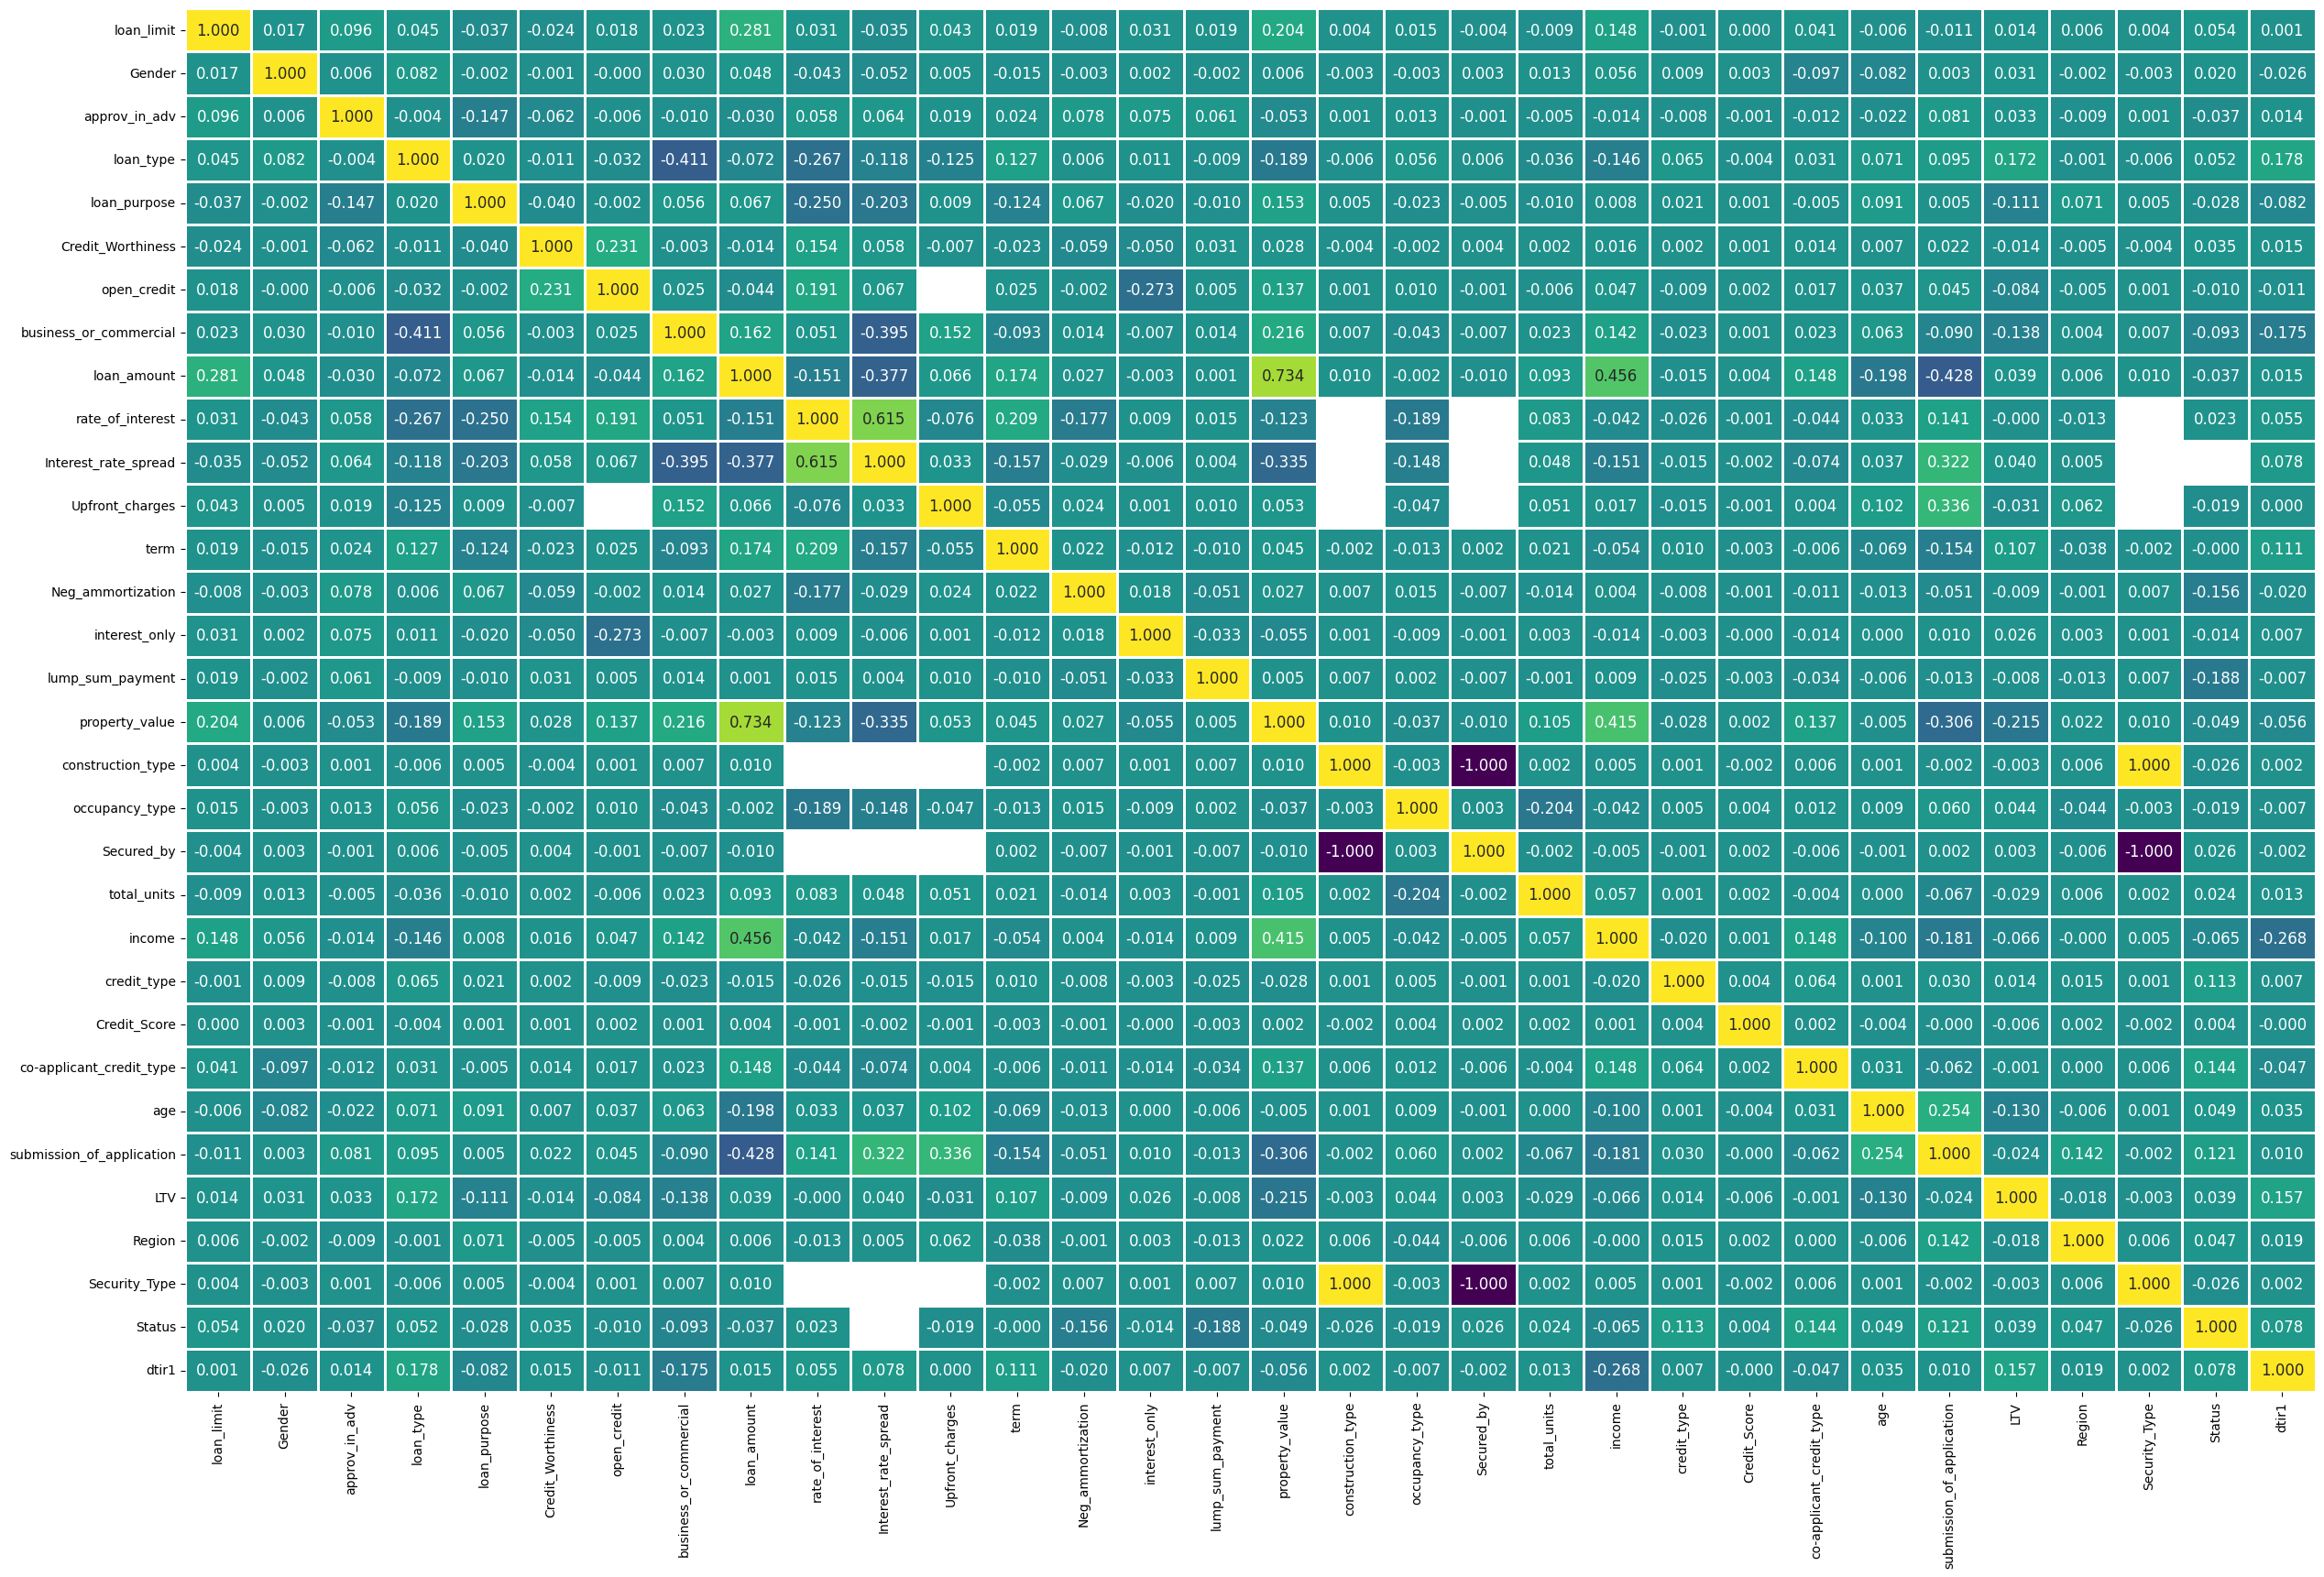

In [22]:
plt.figure(figsize=(30, 20), dpi=100) 
_ = sns.heatmap(corr_map, annot=True, annot_kws={"fontsize":12}, linecolor='white', \
            linewidth=1, fmt='.3f', cmap="viridis", cbar=False)

## Understanding relationship score
<pre>
Correlation value ranging > 0.7 and 1.0, is highly positive/negetive relationship score,
       value > 0.5 and value <= 0.7, is moderate positive/negetive relationship score,
       value > 0.0 and value <= 0.5, is low positive/negetive relationship score, and
       value == 0.0, is no relationship at all.
</pre>

### This big heatmap can be difficult to read, run the cell below to to create a dictionary and categorise low, moderate and high correlation which another feature.
### The code below checks only for one feature's relation with another one feature, there is a possibility that a feature vector may be multicoliniarity please check the heatmap for that.

In [23]:
corr_label = np.array(["high", "moderate", "low", "no"])
pos_neg_corr_label = np.array(["positive", "negative"])

correlations = {}
for column in cols_with_na_values:
    dict_ = corr_map[column].drop(labels=column).to_dict()
    values = list(dict_.values())
    keys = list(dict_.keys())
    value = max( [abs(min(values)), abs(max(values))] )
    relation = ([
        value > 0.7 and value <= 1.0, 
        value > 0.5 and value <= 0.7,
        value > 0.0 and value <= 0.5, 
        value == 0.0,
    ]) 
    try:
        key = keys[values.index(value)]
    except ValueError:
        value *= -1
        key = keys[values.index(value)]    
    cor_label = corr_label[relation][0]
    if cor_label in correlations.keys():
        temp = correlations.get(cor_label)
        temp[column] = [value, key]
        correlations[cor_label].update(temp)
    else:
        correlations[cor_label] = {column: [value, key]}
    print (f"{column} has {corr_label[relation][0]} {pos_neg_corr_label[[value >= 0, value < 0]][0]} " +\
    f"correlation with {key} as {value:.2f}")

loan_limit has low positive correlation with loan_amount as 0.28
approv_in_adv has low negative correlation with loan_purpose as -0.15
Neg_ammortization has low negative correlation with rate_of_interest as -0.18
age has low positive correlation with submission_of_application as 0.25
income has low positive correlation with loan_amount as 0.46
term has low positive correlation with rate_of_interest as 0.21
dtir1 has low negative correlation with income as -0.27
loan_purpose has low negative correlation with rate_of_interest as -0.25
LTV has low negative correlation with property_value as -0.22
property_value has high positive correlation with loan_amount as 0.73
submission_of_application has low negative correlation with loan_amount as -0.43
rate_of_interest has moderate positive correlation with Interest_rate_spread as 0.61
Upfront_charges has low positive correlation with submission_of_application as 0.34
Interest_rate_spread has moderate positive correlation with rate_of_interest as

In [24]:
correlations

{'low': {'loan_limit': [0.28101619539021433, 'loan_amount'],
  'approv_in_adv': [-0.14706742459037656, 'loan_purpose'],
  'Neg_ammortization': [-0.17665774226592168, 'rate_of_interest'],
  'age': [0.25366332102894346, 'submission_of_application'],
  'income': [0.45606544759624623, 'loan_amount'],
  'term': [0.20933032548983713, 'rate_of_interest'],
  'dtir1': [-0.26780661055432065, 'income'],
  'loan_purpose': [-0.25017695163739245, 'rate_of_interest'],
  'LTV': [-0.2151017414188301, 'property_value'],
  'submission_of_application': [-0.4284981769972813, 'loan_amount'],
  'Upfront_charges': [0.335823082050162, 'submission_of_application'],
  'Gender': [-0.0972018736301115, 'co-applicant_credit_type']},
 'high': {'property_value': [0.7342490169595312, 'loan_amount']},
 'moderate': {'rate_of_interest': [0.6149080846899242, 'Interest_rate_spread'],
  'Interest_rate_spread': [0.6149080846899242, 'rate_of_interest']}}

### Given that we have significant relationship with another feature column and all the NaN values of feature X are present in feature vector y, we can make a model to predict missing values
For Ex: Finding the total missing values in the feature vector ```DTIR1``` is ```24121``` and ```DTIR1``` feature has ```-0.27``` relation with feature vector ```INCOME```, out of those ```24121``` missing values in ```DTIR1```, ```15081``` are present in ```INCOME``` feature vector and ```9040``` are null.

In [25]:
for cor in correlations.keys():
    print ('\n', '-'*10, 'Correlation:', cor.upper(), '-'*10, '\n')
    for sub in correlations.get(cor):
        temp = correlations.get(cor).get(sub)
        temp_data = dataset[[sub,temp[1]]]
        final = temp_data[ temp_data[sub].isnull() ][temp[1]].isnull().sum()
        print (f"{sub.upper()} vs. {temp[1].upper()}: Corr: {temp[0]:.2f}")
        print (f"Out of {temp_data[sub].isnull().sum()} nan values in feature {sub.upper()}, " +\
               f"{temp_data[sub].isnull().sum()-final} in {temp[1].upper()} are present and {final} are absent\n")
del temp, temp_data, final


 ---------- Correlation: LOW ---------- 

LOAN_LIMIT vs. LOAN_AMOUNT: Corr: 0.28
Out of 3344 nan values in feature LOAN_LIMIT, 3344 in LOAN_AMOUNT are present and 0 are absent

APPROV_IN_ADV vs. LOAN_PURPOSE: Corr: -0.15
Out of 908 nan values in feature APPROV_IN_ADV, 908 in LOAN_PURPOSE are present and 0 are absent

NEG_AMMORTIZATION vs. RATE_OF_INTEREST: Corr: -0.18
Out of 121 nan values in feature NEG_AMMORTIZATION, 89 in RATE_OF_INTEREST are present and 32 are absent

AGE vs. SUBMISSION_OF_APPLICATION: Corr: 0.25
Out of 200 nan values in feature AGE, 0 in SUBMISSION_OF_APPLICATION are present and 200 are absent

INCOME vs. LOAN_AMOUNT: Corr: 0.46
Out of 9150 nan values in feature INCOME, 9150 in LOAN_AMOUNT are present and 0 are absent

TERM vs. RATE_OF_INTEREST: Corr: 0.21
Out of 41 nan values in feature TERM, 26 in RATE_OF_INTEREST are present and 15 are absent

DTIR1 vs. INCOME: Corr: -0.27
Out of 24121 nan values in feature DTIR1, 15081 in INCOME are present and 9040 are absen

### As we can see that feature vector ```PROPERTY_VALUE``` is linearaly related with feature vector ```LOAN_AMOUNT``` and all the values which are null in ```PROPERTY_VALUE``` are present in feature vector ```LOAN_AMOUNT```

Let's try plotting the data to see how it looks

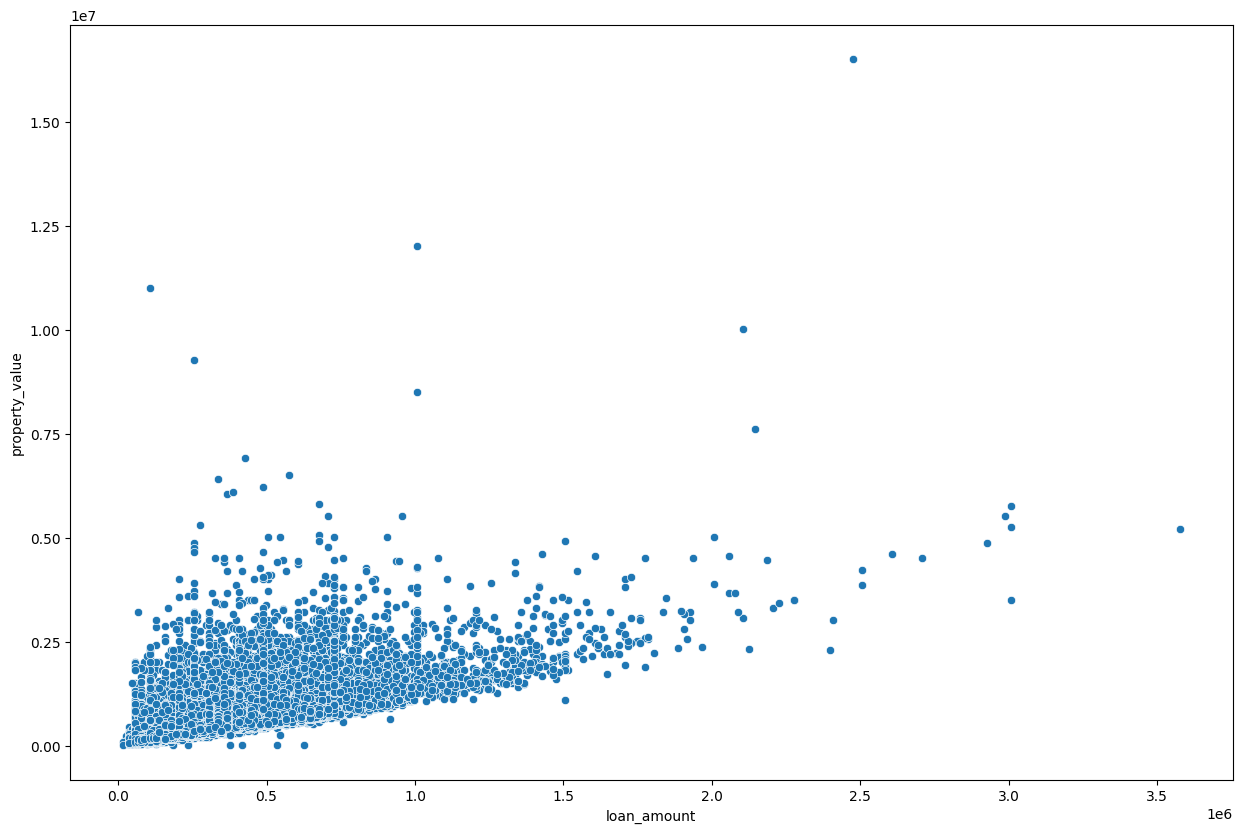

In [26]:
plt.figure(figsize=(15, 10), dpi=100)
_ = sns.scatterplot(x="loan_amount", y="property_value", data=dataset.to_pandas())

## Observations:

1. From the graph we can see there is linear relationship between two features but it's not as much that linear regression can fit the data well.
2. Though LinearRegression cannot fit the data well, we will try with LinearRegression and RandomForestRegressor.
3. We can see in the graph that LinearRegression is not going to be able to fit to this data

### Model building for NA Values in "loan_amount" feature using "property_value" feature

### StandardScaling the feature vectors X (loan_amount) and y (property_value)

In [27]:
from cuml.preprocessing import StandardScaler

In [28]:
data = dataset.loc[dataset["property_value"].notnull(), ["property_value", "loan_amount"]]

scaler = StandardScaler(with_mean=True, with_std=True)
data = scaler.fit_transform(data)
X = data.iloc[:,1]
y = data.iloc[:,0]

if X.dtype != np.float32:
    X = X.astype(np.float32)
    print (f"Converting X to {X.dtype}")
if y.dtype != np.float32:
    y = y.astype(np.float32)
    print (f"Converting y to {y.dtype}")

data.describe()

Converting X to float32
Converting y to float32


,0,1
count,133572.000000,133572.000000
mean,-0.000000,0.000000
std,1.000004,1.000004
min,-1.361065,-1.731810
25%,-0.638710,-0.741438
50%,-0.221967,-0.191230
75%,0.361473,0.579059
max,44.480677,17.855562


### Model Creation
Applying LinearRegression and RandomForest algoritms to X = "property_value" and y = "loan_amount"

In [29]:
from cuml.linear_model import LinearRegression
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid, StratifiedKFold

In [30]:
print (f"Number of samples for training: {X.shape} the model")

params = {
#     'eig' solver does not support training data with 1 column currently. rapids v22.02
    'algorithm': ['svd', 'qr', 'svd-qr', 'svd-jacobi'],
}

total_n_perm = len(ParameterGrid(param_grid=params))
print (f"Total number of permutations need to run by GridSearchCV is {total_n_perm}")

gcv = GridSearchCV(LinearRegression(), params, cv = 5, return_train_score=True)
gcv.fit(X.copy(), y.copy())

print ('best solver:', gcv.best_estimator_)
print ('best params:', gcv.best_params_)
print ('best score:', gcv.best_score_)
print ('estimator:', gcv.estimator)
print ('train score:', gcv.best_estimator_.score(X, y))

Number of samples for training: (133572,) the model
Total number of permutations need to run by GridSearchCV is 4


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


best solver: LinearRegression()
best params: {'algorithm': 'svd'}
best score: 0.5394865870475769
estimator: LinearRegression()
train score: 0.5391216278076172


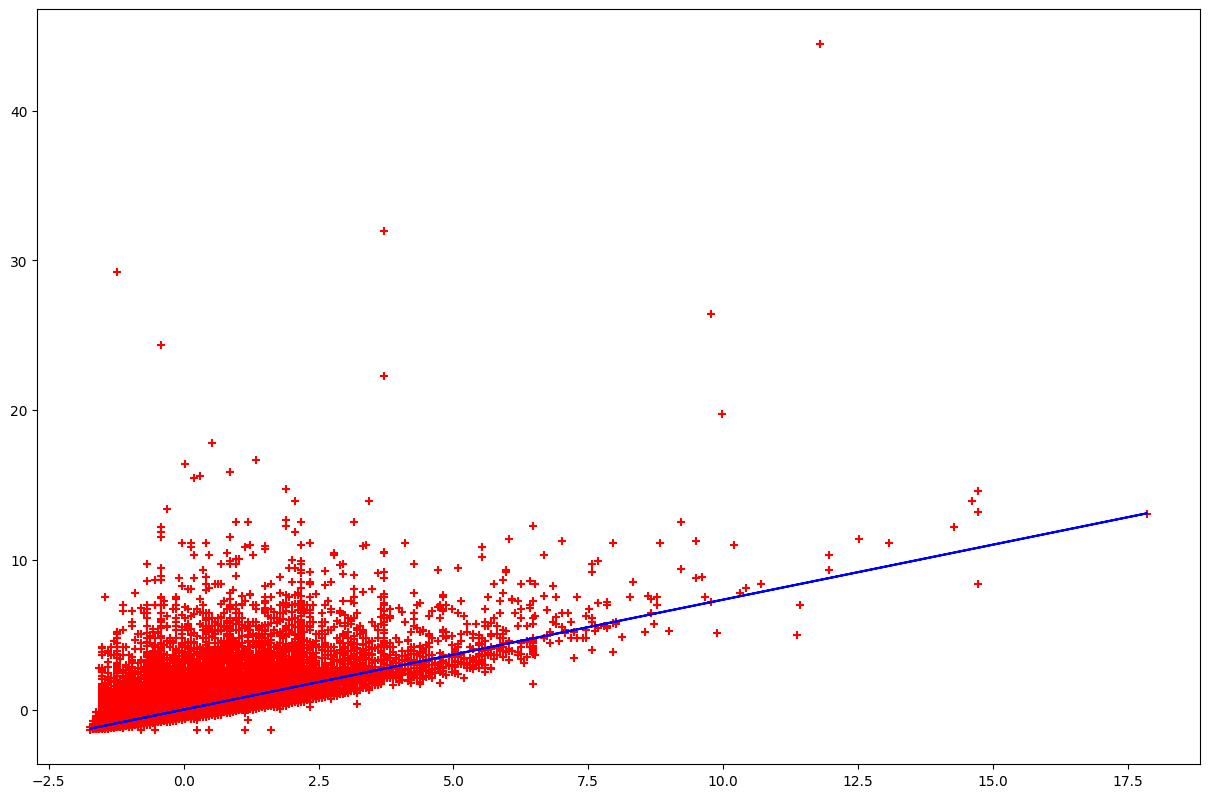

In [31]:
plt.figure(figsize=(15, 10), dpi=100)

model_lr = gcv.best_estimator_

_ = plt.scatter(X.to_array(), y.to_array(), color='red', marker='+')
_ = plt.plot(X.to_array(), model_lr.predict(X).to_array(), color='blue')

In [32]:
from cuml.ensemble import RandomForestRegressor

In [33]:
print (f"Number of samples for training: {X.shape}")

params = {
    'n_estimators': [x for x in range(10, 101, 5)],
}

total_n_perm = len(ParameterGrid(param_grid=params))
print (f"Total number of permutations need to run by GridSearchCV is {total_n_perm}")

gcv = GridSearchCV(RandomForestRegressor(), params, cv=5, return_train_score=True)
gcv.fit(X.copy(), y.copy())

print ('best solver:', gcv.best_estimator_)
print ('best params:', gcv.best_params_)
print ('best score:', gcv.best_score_)
print ('estimator:', gcv.estimator)
print ('train score:', gcv.score(X, y))

Number of samples for training: (133572,)
Total number of permutations need to run by GridSearchCV is 19
best solver: RandomForestRegressor()
best params: {'n_estimators': 70}
best score: 0.5292803168296814
estimator: RandomForestRegressor()
train score: 0.5294827222824097


### Visualizing all 5 cross-validation results with DataFrame.

In [34]:
cudf.DataFrame(gcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.080273,0.004911,0.005563,0.000836,10,{'n_estimators': 10},0.514145,0.520295,0.545969,0.516505,0.549164,0.529215,0.015145,19,0.533174,0.531735,0.525395,0.532916,0.524455,0.529535,0.003807
1,0.105078,0.000556,0.005017,0.000324,15,{'n_estimators': 15},0.514089,0.520332,0.545980,0.516480,0.549299,0.529236,0.015194,18,0.533171,0.531749,0.525412,0.532928,0.524467,0.529545,0.003803
2,0.136719,0.001026,0.004936,0.000058,20,{'n_estimators': 20},0.514108,0.520339,0.546021,0.516520,0.549272,0.529252,0.015185,15,0.533175,0.531755,0.525418,0.532929,0.524466,0.529549,0.003804
3,0.172229,0.005780,0.005558,0.000804,25,{'n_estimators': 25},0.514136,0.520301,0.546096,0.516423,0.549289,0.529249,0.015221,16,0.533182,0.531759,0.525427,0.532936,0.524472,0.529555,0.003803
4,0.200174,0.000224,0.006414,0.000491,30,{'n_estimators': 30},0.514155,0.520322,0.546100,0.516371,0.549293,0.529248,0.015225,17,0.533186,0.531762,0.525428,0.532938,0.524475,0.529558,0.003804
5,0.235539,0.001885,0.006039,0.000625,35,{'n_estimators': 35},0.514151,0.520327,0.546099,0.516396,0.549324,0.529259,0.015230,14,0.533189,0.531764,0.525428,0.532940,0.524478,0.529560,0.003804
6,0.263515,0.001435,0.007565,0.001600,40,{'n_estimators': 40},0.514150,0.520332,0.546117,0.516382,0.549347,0.529266,0.015241,12,0.533189,0.531762,0.525429,0.532941,0.524478,0.529560,0.003804
7,0.299606,0.013112,0.011886,0.007881,45,{'n_estimators': 45},0.514131,0.520344,0.546100,0.516399,0.549346,0.529264,0.015237,13,0.533189,0.531763,0.525429,0.532941,0.524478,0.529560,0.003804
8,0.413359,0.083364,0.033778,0.033219,50,{'n_estimators': 50},0.514132,0.520341,0.546123,0.516368,0.549383,0.529270,0.015257,10,0.533190,0.531765,0.525431,0.532942,0.524480,0.529562,0.003803
9,0.361226,0.001844,0.009671,0.001153,55,{'n_estimators': 55},0.514139,0.520331,0.546138,0.516337,0.549435,0.529276,0.015279,8,0.533192,0.531766,0.525431,0.532942,0.524481,0.529563,0.003804


### The accuracy we are getting with LinearRegression or RandomForestRegression is not enough for us to use the trained model.
### We tried building the model with 2 feature vectors which had highest correlation score, with that we got ~0.54 accuracy, this makes it clear that we are not going get good model with correlation score any lower than that.

### We can predict missing values in the feature vector ```loan_amount``` with this model.

In [35]:
missing_vals = dataset.loc[dataset["property_value"].isnull(), ["loan_amount",]].copy()
missing_vals = scaler.fit_transform(missing_vals)

model_rf = gcv.best_estimator_

model_rf.predict(missing_vals)

0       -0.455287
1        0.465828
2        0.508589
3       -0.670937
4       -0.599134
           ...   
15093   -0.236544
15094   -0.287473
15095   -0.754280
15096    0.156602
15097   -0.761049
Length: 15098, dtype: float32

### Since, building a model is not going to work because of low correlation score, we will replace the missing values with mode value of each class status

In [36]:
status_vals = dataset["Status"].unique().values.tolist()

In [37]:
for status in status_vals:
    if status is np.nan:
        print ("Status value is NaN")
        continue
    total_samples = dataset[dataset["Status"] == status].shape[0]
    max_null_vals = np.max(dataset[dataset["Status"] == status].isnull().sum().values)
    msg = f"Total samples with status as {status} are {total_samples} out of those {max_null_vals} " +\
    "samples have null values"
    print (msg)

Total samples with status as 0 are 112031 out of those 26892 samples have null values
Total samples with status as 1 are 36639 out of those 36639 samples have null values


### Replacing null values in categorical features with mode of the feature status i.e. 0 or 1 and continous features with median value of that feature vector.

In [38]:
for col in dataset.columns:
    if dataset[col].isnull().sum() > 0:
        for status in status_vals:
            if col in categorical_columns:
                vec_type_value = ("categorical", "mode")
                value = dataset.loc[dataset["Status"] == status, col].mode().to_arrow().to_pylist()[0]
            else:
                vec_type_value = ("continuous", "median")
                value = dataset.loc[dataset["Status"] == status, col].median()
            print (f"Replacing {vec_type_value[0]} feature vector \"{col}\" where status: {status} with " +\
                   f"{vec_type_value[1]}: {value:.3f}")
            if str(np.nan) != str(value):
                dataset.loc[dataset["Status"] == status, col] = dataset.loc[dataset["Status"] == status, col].fillna(value=value)
            else:
                print (f"--->> Skipping {vec_type_value[0]} feature vector \"{col}\" as {vec_type_value[1]} is {np.nan}")
    else:
        print (f"** There are no null values in feature vector \"{col}\" **")

Replacing categorical feature vector "loan_limit" where status: 0 with mode: 0.000
Replacing categorical feature vector "loan_limit" where status: 1 with mode: 0.000
Replacing categorical feature vector "Gender" where status: 0 with mode: 1.000
Replacing categorical feature vector "Gender" where status: 1 with mode: 2.000
Replacing categorical feature vector "approv_in_adv" where status: 0 with mode: 0.000
Replacing categorical feature vector "approv_in_adv" where status: 1 with mode: 0.000
** There are no null values in feature vector "loan_type" **
Replacing categorical feature vector "loan_purpose" where status: 0 with mode: 3.000
Replacing categorical feature vector "loan_purpose" where status: 1 with mode: 2.000
** There are no null values in feature vector "Credit_Worthiness" **
** There are no null values in feature vector "open_credit" **
** There are no null values in feature vector "business_or_commercial" **
** There are no null values in feature vector "loan_amount" **
Repl

### Checking if any null values are still left in any feature vectors

In [39]:
print (dataset.isnull().sum())

loan_limit                       0
Gender                           0
approv_in_adv                    0
loan_type                        0
loan_purpose                     0
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest                 0
Interest_rate_spread         36639
Upfront_charges                  0
term                             0
Neg_ammortization                0
interest_only                    0
lump_sum_payment                 0
property_value                   0
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                           0
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                              0
submission_of_application        0
LTV                              0
Region              

### There is 1 feature vectors ```Interest_rate_spread``` which still has large number of null values.

Let's check the relationship of this features with dependent feature "Status", if there is no significant correlation of these features with "Status" feature then we can drop it.

We can use code in the code below or you can check heatmap we generated above.

In [40]:
dataset[["Interest_rate_spread",]].to_pandas().corrwith(dataset["Status"].to_pandas(), axis=0)

Interest_rate_spread   NaN
dtype: float64

### As we can see that there is no significant correlation of the feature vectors ```Interest_rate_spread``` with dependent feature vector ```Status```, we can simply drop these feature vectors.

In [41]:
dataset.drop(["Interest_rate_spread",], axis=1, inplace=True)
print (dataset.shape)

(148670, 31)


## train_test_split dataset
* We will split the data into 80, 20 split ratio for train and test dataset
* We will fit StandardScaler on X_train data and using that scaler object, we will transform X_train and X_test both to avoid data leak problem.

In [42]:
from cuml.model_selection import train_test_split

In [43]:
y = dataset["Status"].copy()
dt2 = dataset.drop(["Status", ], axis=1, inplace=False).copy()
X = dt2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99, test_size = 0.2, shuffle = False, stratify = y)

Resetting index

In [44]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace = True, drop=True)
y_test.reset_index(inplace = True, drop=True)

In [45]:
X_test.head(5)

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,dtir1
0,0,0,0,0,2,0,0,1,126500,4.3125,687.849976,360.0,1,1,0,348000.0,1,1,0,0,2640.0,2,823,1,6,1,79.362419,1,1,42.0
1,0,0,0,1,2,0,0,0,176500,3.9900,3687.169922,360.0,1,0,1,208000.0,1,1,0,0,3600.0,3,672,0,3,1,84.855766,2,1,42.0
2,0,2,0,0,3,0,0,1,166500,4.3125,687.849976,180.0,0,1,1,348000.0,1,1,0,0,6240.0,2,578,1,2,1,79.362419,3,1,42.0
3,0,2,0,2,3,0,0,1,266500,2.9900,3689.610107,360.0,1,1,1,358000.0,1,1,0,0,6000.0,3,650,0,3,1,74.441338,0,1,38.0
4,0,0,0,0,0,0,0,1,266500,4.3750,5200.000000,360.0,1,1,1,328000.0,1,1,0,0,3840.0,0,805,0,0,0,81.250000,0,1,30.0


## Notes:

#### Before we apply any algorithm to our data we need to scale the data and scaling the entire dataset can lead to "data leak" problem.
#### To avoid this we will split the data to train and test first and we will fit the scaler object to train data and use the same scaler object to transform (apply) both train and test dataset.
#### We will use the same train and test split through out all the algorithms.

## Feature scaling

Continuous feature vectors can range between very nigh to very low values, thus not following gaussian distribution and this can affect our model in significant way.

We need perform feature scaling to convert feature vectors to standard normal distribution.

### But first we need to find what are the continuous feature vectors in our dataset.

In [46]:
continuous_columns = list(set(dataset.columns.values.tolist()) - set(categorical_columns))

In [47]:
print (f"In our dataset we have {len(continuous_columns)} continuous feature vectors.")

In our dataset we have 9 continuous feature vectors.


In [48]:
dataset[continuous_columns].head(5)

,loan_amount,LTV,Upfront_charges,property_value,income,rate_of_interest,term,Credit_Score,dtir1
0,116500,98.728813,687.849976,118000.0,1740.0,4.3125,360.0,758,45.0
1,206500,79.362419,687.849976,348000.0,4980.0,4.3125,360.0,552,42.0
2,406500,80.019684,595.000000,508000.0,9480.0,4.5600,360.0,834,46.0
3,456500,69.376900,2600.000000,658000.0,11880.0,4.2500,360.0,587,42.0
4,696500,91.886543,0.000000,758000.0,10440.0,4.0000,360.0,602,39.0


### Checking the range of values in these feature vectors

In [49]:
scale_columns = []
for column in dataset[continuous_columns].columns:
    min_ = int(dataset[column].min())
    max_ = int(dataset[column].max())
    print (f"Feature {column} ranges between {min_} and {max_}")
    scale_columns.append(column)

Feature loan_amount ranges between 16500 and 3576500
Feature LTV ranges between 0 and 7831
Feature Upfront_charges ranges between 0 and 60000
Feature property_value ranges between 8000 and 16508000
Feature income ranges between 0 and 578580
Feature rate_of_interest ranges between 0 and 8
Feature term ranges between 96 and 360
Feature Credit_Score ranges between 500 and 900
Feature dtir1 ranges between 5 and 61


## Applying StandardScaler.

In [50]:
scaler = StandardScaler(with_mean=True, with_std=True)

if len(scale_columns) > 1:
    columns = {0: scale_columns[0], 1: scale_columns[1], 2: scale_columns[2], 3: scale_columns[3], \
               4: scale_columns[4], 5: scale_columns[5], 6: scale_columns[6], 7: scale_columns[7],
              }
    scaler = scaler.fit(X_train[scale_columns])
    X_train[scale_columns] = scaler.transform(X_train[scale_columns].copy()).rename(columns = columns)
    X_test[scale_columns] = scaler.transform(X_test[scale_columns].copy()).rename(columns = columns)
elif len(scale_columns) == 1:
    scaler.fit(X_train[scale_columns].values.reshape(-1, 1))
    X_train[scale_columns] = scaler.transform(X_train[scale_columns].reshape(-1, 1).copy()).reshape(1, -1)
    X_test[scale_columns] = scaler.transform(X_test[scale_columns].reshape(-1, 1).copy()).reshape(1, -1)

del scaler
X_train[scale_columns].head(5)

,loan_amount,LTV,Upfront_charges,property_value,income,rate_of_interest,term,Credit_Score,dtir1
0,-1.166988,0.617205,-0.636559,-1.051757,-0.800101,0.402450,0.425455,0.501416,0.694200
1,-0.676932,0.143898,-0.636559,-0.387904,-0.296327,0.402450,0.425455,-1.275304,0.385929
2,0.412081,0.159962,-0.667572,0.073906,0.403360,0.896616,0.425455,1.156905,0.796957
3,0.684335,-0.100144,0.002123,0.506853,0.776527,0.277660,0.425455,-0.973434,0.385929
4,1.991151,0.449983,-0.866310,0.795484,0.552627,-0.221497,0.425455,-0.844061,0.077659


## Checking datatype of the columns

StandardScaling can change the datatype of the feature vectors to float64 / int64 from float32 / int32 and NVIDIA libraries are designed to only work with float32 / int32 types of variables. Let's check the datatype of all vectors

In [51]:
X_train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 118936 entries, 0 to 118935
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   loan_limit                 118936 non-null  int32
 1   Gender                     118936 non-null  int32
 2   approv_in_adv              118936 non-null  int32
 3   loan_type                  118936 non-null  int32
 4   loan_purpose               118936 non-null  int32
 5   Credit_Worthiness          118936 non-null  int32
 6   open_credit                118936 non-null  int32
 7   business_or_commercial     118936 non-null  int32
 8   loan_amount                118936 non-null  float64
 9   rate_of_interest           118936 non-null  float64
 10  Upfront_charges            118936 non-null  float64
 11  term                       118936 non-null  float64
 12  Neg_ammortization          118936 non-null  int32
 13  interest_only              118936 non-null  int32

As we can see the all the feature vectors passed to StandardScaler are converted to int64 / float64 vectors, let's change those back.

In [52]:
def change_dtype(dataset):
    for col in dataset.columns:
        if dataset[col].dtype == np.int64:
            dataset[col] = dataset[col].astype(np.int32)
        elif dataset[col].dtype == np.float64:
            dataset[col] = dataset[col].astype(np.float32)
    return dataset

In [53]:
X_train[scale_columns] = change_dtype(X_train[scale_columns])
if y_train.dtype == np.int64:
    y_train = y_train.astype(np.int32)
    print (f"Changing y_train to {y_train.dtype}")

X_test[scale_columns] = change_dtype(X_test[scale_columns])
if y_test.dtype == np.int64:
    y_test = y_test.astype(np.int32)
    print (f"Changing y_train to {y_test.dtype}")

print (X_train.info())
print (X_test.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 118936 entries, 0 to 118935
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   loan_limit                 118936 non-null  int32
 1   Gender                     118936 non-null  int32
 2   approv_in_adv              118936 non-null  int32
 3   loan_type                  118936 non-null  int32
 4   loan_purpose               118936 non-null  int32
 5   Credit_Worthiness          118936 non-null  int32
 6   open_credit                118936 non-null  int32
 7   business_or_commercial     118936 non-null  int32
 8   loan_amount                118936 non-null  float32
 9   rate_of_interest           118936 non-null  float32
 10  Upfront_charges            118936 non-null  float32
 11  term                       118936 non-null  float32
 12  Neg_ammortization          118936 non-null  int32
 13  interest_only              118936 non-null  int32

## Checking for unbalanced dataset

First let's see how much data we have in our test and test split, make sure we have enough number of samples to train the model properly.

In [54]:
print (f"Training dataset shape X_train.shape: {X_train.shape}")
print (f"Training dataset shape y_test.shape: {y_train.shape}")
print ()
print (f"Testing dataset shape X_test.shape: {X_test.shape}")
print (f"Testing dataset shape y_test.shape: {y_test.shape}")

Training dataset shape X_train.shape: (118936, 30)
Training dataset shape y_test.shape: (118936,)

Testing dataset shape X_test.shape: (29734, 30)
Testing dataset shape y_test.shape: (29734,)


### Let's also check that we have enough number training and testing samples for all classes (0, 1)

In [55]:
for status in dataset["Status"].unique().values.tolist():
    print (f"Training samples for class {status}: {X_train[y_train == status].shape[0]}")    
    print (f"Testing samples for class {status}: {X_test[y_test == status].shape[0]}")
    print ()

Training samples for class 0: 89600
Testing samples for class 0: 22431

Training samples for class 1: 29336
Testing samples for class 1: 7303



## Common functions
Following common functions we will be using more than once in the upcoming code

In [56]:
def r2_adjusted(r2, n, p):
    r2_adj = 1 - ((1 - r2) * ((n - 1) / (n - p -1)))
    return r2_adj

### Now, let's create final model we will drop few different ML models here and will check which one is working better.

## RandomForestRegressor Model Training

In [57]:
from cuml.ensemble import RandomForestClassifier

In [58]:
rf = RandomForestClassifier()
rf_reg = rf.fit(X_train.copy(), y_train.copy())

print (f"Train score: {rf_reg.score(X_train.copy(), y_train.copy())}")
print (f"Test score: {rf_reg.score(X_test.copy(), y_test.copy())}")

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Train score: 1.0
Test score: 0.9998990893363953


### To check how many samples we predicted correctly, let's check confusion_matrix

In [59]:
from cuml.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [60]:
y_pred = rf_reg.predict(X_test.copy())
cm = confusion_matrix(y_test, y_pred)

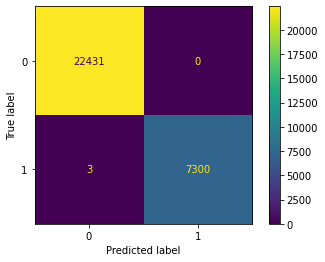

In [61]:
_ = ConfusionMatrixDisplay(cm.get(), display_labels=rf_reg.classes_.to_array()).plot()

### Let's check the classification_report, it'll show us lots of necessary model evaluation details

In [62]:
from sklearn.metrics import classification_report

In [63]:
print (classification_report(y_test.to_array(), y_pred.to_array()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22431
           1       1.00      1.00      1.00      7303

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



### Let's check the R2 score

In [64]:
from sklearn.metrics import r2_score

In [65]:
r2 = r2_score(y_test.to_array(), y_pred.to_array())
print (f"R-suared score: {r2}")

R-suared score: 0.9994554664337287


### R2 adjusted

In [66]:
# r2 squared adjusted
n, p = X_test.shape
r2_adj = r2_adjusted(r2, n, p)
print (f"R-squared adjusted score: {r2_adj}")

R-squared adjusted score: 0.9994549164553768


## MLPClassifier Model Training

In [67]:
from sklearn.neural_network import MLPClassifier

Note: Depending in your machine configuration following block of code may take several hours to execute.

In [68]:
# print (f"Number of samples for training: {X_train.shape} the model")

# skf = StratifiedKFold(n_splits=5, shuffle=True)

# # batch_size = 1000
# max_iter = 10000 #X_train.shape[0] // batch_size # number of epochs

# params = {
#     'hidden_layer_sizes': [
#         (20, 20), (25, 25),
#     ],
#     'activation': ['relu', ],
#     'learning_rate': [
#         'adaptive','constant',
#     ],
#     'learning_rate_init': [
#         1e-2, 3e-2, 1e-3, 3e-3, 1e-4, 3e-4,
#     ],
#     'alpha': [
#         1e-5, 3e-5, 1e-6, 3e-6,
#     ],
#     'tol': [
#         1e-4, 1e-5,
#     ],
#     'early_stopping': [True,],
#     'n_iter_no_change': [10, ],
#     'max_iter': [max_iter, ],
#     'solver': [
#         'lbfgs', 'sgd', 'adam',
#     ],
# #     'batch_size': [batch_size, ],
#     'validation_fraction': [0.2, ],
#     'shuffle': [True, ],
#     'verbose': [True, ],
# }

# total_n_perm = len(ParameterGrid(param_grid=params))
# print (f"Total number of permutations need to run by GridSearchCV is {total_n_perm}")

# gcv = GridSearchCV(MLPClassifier(), params, cv=skf, return_train_score=True)
# gcv.fit(X_train.to_pandas().to_numpy(), y_train.to_pandas().to_numpy())

# print ('best solver:', gcv.best_estimator_)
# print ('best params:', gcv.best_params_)
# print ('best score:', gcv.best_score_)
# print ('estimator:', gcv.estimator)

# mlp = gcv.best_estimator_

# print (f"Train score: {mlp.score(X_train.to_pandas().to_numpy(), y_train.to_pandas().to_numpy())}")
# print (f"Test score: {mlp.score(X_test.to_pandas().to_numpy(), y_test.to_pandas().to_numpy())}")

You can comment the following cell in case you are the above GridSearchCV classfication

In [69]:
mlp = MLPClassifier(
    hidden_layer_sizes = (20, 20),
    activation = 'relu',
    alpha = 1e-5,
    learning_rate = 'adaptive',
    learning_rate_init = 1e-3,
    tol = 1e-6,
    early_stopping = True,
    validation_fraction = 2e-1,
    n_iter_no_change = 50,
    max_iter = 1000,
    solver = 'adam', # 'lbfgs', 'sgd'
)

print (mlp.fit(X_train.to_pandas().to_numpy(), y_train.to_pandas().to_numpy()))

print (f"iterations ran: {mlp.n_iter_}")
print (f"Train score: {mlp.score(X_train.to_pandas().to_numpy(), y_train.to_pandas().to_numpy())}")
print (f"Test score: {mlp.score(X_test.to_pandas().to_numpy(), y_test.to_pandas().to_numpy())}")

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(20, 20),
              learning_rate='adaptive', max_iter=1000, n_iter_no_change=50,
              tol=1e-06, validation_fraction=0.2)
iterations ran: 108
Train score: 0.9998066186856797
Test score: 0.9997309477365979


## Visualizing all 5 cross-validation results with DataFrame.
Note: Uncomment the following cell in case you have not used GridSearchCV for MLPClassifier

In [70]:
# cudf.DataFrame(gcv.cv_results_)

### To check how many samples we predicted correctly, let's check confusion_matrix

In [71]:
from cuml.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [72]:
y_pred = mlp.predict(X_test.to_pandas().to_numpy())

In [73]:
cm = confusion_matrix(y_test, y_pred)

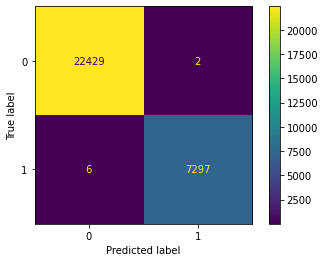

In [74]:
_ = ConfusionMatrixDisplay(cm.get(), display_labels=rf_reg.classes_.to_pandas().to_numpy()).plot()

### Let's check the classification_report, it'll show us lots of necessary model evaluation details

In [75]:
from sklearn.metrics import classification_report

In [76]:
print (classification_report(y_test.to_pandas().to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22431
           1       1.00      1.00      1.00      7303

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



### Let's check the R2 score

In [77]:
from sklearn.metrics import r2_score

In [78]:
r2 = r2_score(y_test.to_pandas().to_numpy(), y_pred)
print (f"R-suared score: {r2}")

R-suared score: 0.9985479104899433


### R2 adjusted

In [79]:
# r2 squared adjusted
n, p = X_test.shape
r2_dj = r2_adjusted(r2, n, p)
print (f"R-squared adjusted score: {r2_adj}")

R-squared adjusted score: 0.9994549164553768


## Model training using ANN (Keras)

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential

In [81]:
model_ann = Sequential(name="loan-defaulter-keras-ann")
model_ann.add( InputLayer(input_shape = (X_train.shape[1],), name="keras-input-layer") )
model_ann.add( Dense(units = 35, activation = 'leaky_relu', use_bias = True, name = 'second-dense-35-units') )
model_ann.add( Dense(units = 35, activation = 'leaky_relu', use_bias = True, name = 'third-dense-35-units') )
model_ann.add( Dense(units = 35, activation = 'leaky_relu', use_bias = True, name = 'fourth-dense-35-units') )
model_ann.add( Dense(units = 1, activation = 'sigmoid', use_bias = True, name = 'output_sigmoid') )
model_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'mse'])
model_ann.summary()

Model: "loan-defaulter-keras-ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
second-dense-35-units (Dense (None, 35)                1085      
_________________________________________________________________
third-dense-35-units (Dense) (None, 35)                1260      
_________________________________________________________________
fourth-dense-35-units (Dense (None, 35)                1260      
_________________________________________________________________
output_sigmoid (Dense)       (None, 1)                 36        
Total params: 3,641
Trainable params: 3,641
Non-trainable params: 0
_________________________________________________________________


2022-02-28 07:32:15.900663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 07:32:15.901814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 07:32:15.902419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 07:32:15.903186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [82]:
batch_size = 1000
epochs = X_train.shape[0] // batch_size

hist = model_ann.fit(
    X_train.to_pandas(), 
    y_train.to_pandas(),
    validation_data = (X_test.to_pandas(), y_test.to_pandas()), 
    epochs = epochs, 
    batch_size = batch_size,
    verbose = 1,
    use_multiprocessing = True,
)

2022-02-28 07:32:16.782370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/118
119/119 [==============================] - 1s 5ms/step - loss: 0.4396 - accuracy: 0.7830 - mse: 0.1448 - val_loss: 0.2820 - val_accuracy: 0.8697 - val_mse: 0.0900
Epoch 2/118
119/119 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.9076 - mse: 0.0650 - val_loss: 0.1482 - val_accuracy: 0.9379 - val_mse: 0.0448
Epoch 3/118
119/119 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9559 - mse: 0.0327 - val_loss: 0.0882 - val_accuracy: 0.9676 - val_mse: 0.0242
Epoch 4/118
119/119 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9728 - mse: 0.0204 - val_loss: 0.0671 - val_accuracy: 0.9772 - val_mse: 0.0173
Epoch 5/118
119/119 [==============================] - 0s 4ms/step - loss: 0.0622 - accuracy: 0.9816 - mse: 0.0147 - val_loss: 0.0555 - val_accuracy: 0.9845 - val_mse: 0.0124
Epoch 6/118
119/119 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.9869 - mse: 0.0111 - val_loss

### Model Evaluation

In [83]:
loss, acc, mse = model_ann.evaluate(X_test.to_pandas().to_numpy(), y_test.to_pandas().to_numpy())

930/930 [==============================] - 3s 3ms/step - loss: 0.0013 - accuracy: 0.9997 - mse: 2.7859e-04


In [84]:
print (f"Loss: {loss:.3f}, Accuracy: {acc:.3f} and MSE: {mse:.3f}")

Loss: 0.001, Accuracy: 1.000 and MSE: 0.000


### To check how many samples we predicted correctly, let's check confusion_matrix

In [85]:
from cuml.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [86]:
y_pred = model_ann.predict(X_test.to_pandas().to_numpy()).round().astype(np.int32)[:,0]

In [87]:
cm = confusion_matrix(y_test, y_pred)

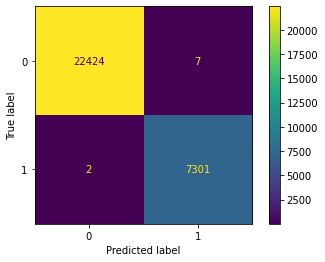

In [88]:
_ = ConfusionMatrixDisplay(cm.get(), display_labels=rf_reg.classes_.to_array()).plot()

### Let's check the classification_report, it'll show us lots of necessary model evaluation details

In [89]:
from sklearn.metrics import classification_report

In [90]:
print (classification_report(y_test.to_array(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22431
           1       1.00      1.00      1.00      7303

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



### Let's check the R2 score

In [91]:
from sklearn.metrics import r2_score

In [92]:
r2 = r2_score(y_test.to_array(), y_pred)
print (f"R-suared score: {r2}")

R-suared score: 0.9983663993011862


### R2 adjusted

In [93]:
# r2 squared adjusted
n, p = X_test.shape
r2_adj = r2_adjusted(r2, n, p)
print (f"R-squared adjusted score: {r2_adj}")

R-squared adjusted score: 0.9983647493661303


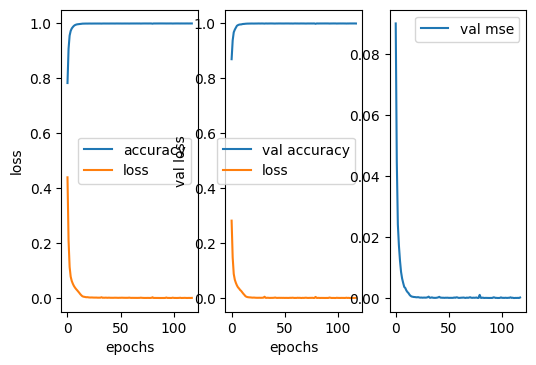

In [94]:
fig, axs = plt.subplots(1, 3)
fig.figure = (24, 10)
fig.dpi = 100

axs[0].plot(hist.history['accuracy'], label="accuracy")
axs[0].plot(hist.history['loss'], label="loss")

axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()

axs[1].plot(hist.history['val_accuracy'], label="val accuracy")
axs[1].plot(hist.history['val_loss'], label="loss")

axs[1].set_xlabel("epochs")
axs[1].set_ylabel("val loss")
axs[1].legend()

axs[2].plot(hist.history['val_mse'], label="val mse")
axs[2].legend()